# Exercise 2: Boosting

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.
* Kind reminder: the homework assignments contribute 60% of the final grade.


## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
---

## Please sign that you have read and understood the instructions:

### *** YOUR ID HERE ***

---
---


In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.datasets import make_moons, make_classification, make_gaussian_quantiles
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    roc_curve
)
from sklearn.inspection import DecisionBoundaryDisplay
from matplotlib.colors import ListedColormap

# Set random seed for reproducibility
np.random.seed(42)


# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

### Design and Theoretical Considerations for AdaBoost

**Design Overview**

The AdaBoost algorithm combines multiple weak classifiers into a strong ensemble model through an iterative boosting process. Each weak classifier focuses on correcting the errors of its predecessors by adapting sample weights. This process emphasizes misclassified samples, ensuring that subsequent weak classifiers improve upon previous iterations.

**Theoretical Considerations**

1. **Initialization**:  
   - Uniformly initialize sample weights so that each sample contributes equally during the first iteration.

2. **Weight Updates**:  
   - Update weights after each iteration based on the classification errors of the current weak hypothesis. Misclassified samples receive higher weights to emphsyzed them during subsequent classifiers.

3. **Iterative Boosting Steps**:  
   - Train weak classifiers sequentially.
   - Calculate their weighted errors (epsilon).
   - Assign a confidence value (alpha) to each weak classifier, proportional to its accuracy - higher accuracy higher alpha (higher step toward destination).

4. **Combination of Weak Classifiers**:  
   - Aggregate predictions of weak classifiers using a weighted sum, determined by their alpha values.

**Practical Considerations**

1. **Hyperparameters**:  
   - `num_iterations`: Number of weak classifiers to train. A higher value can improve accuracy but risks overfitting - what we learn in the class is not likely in adaboost.
   - Choice of weak learner: Decision stumps are commonly used.

2. **Limitations**:  
   - Sensitive to noisy data and outliers, as they receive higher weights during training.
   - Requires labels to be binary (-1 or 1).

3. **Use Cases**:  
   - Classification tasks in domains like image recognition, text classification, and fraud detection.
   - Situations requiring interpretable models, as weak classifiers and their weights can provide insights into feature importance.

4. **Optimization Strategies**:  
   - Early stopping when weighted error becomes too high.
   - Efficient calculation of weighted errors using vectorized operations.



# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

### Implementation Details and Code Explanation

**Class Overview**

The `AdaBoostCustom` class implements the AdaBoost algorithm with methods for initialization, training, and prediction.

**Method Descriptions**

1. `__init__`:  
   - Initializes the AdaBoost model with `num_iterations`, storing weak classifiers and their weights (`alphas`).

2. `initialize_weights`:  
   - Initializes sample weights uniformly: $( w_i = \frac{1}{n} $).

3. `find_weak_hypothesis`:  
   - Searches for the best weak hypothesis by iterating over features, thresholds, and polarities. Evaluates each hypothesis based on the weighted classification error.

4. `calculate_weighted_error`:  
   - Computes the weighted error for a given hypothesis.

5. `is_weak_hypothesis_valid`:  
   - Ensures weak hypothesis validity: $( \epsilon < 0.5 $).

6. `calculate_alpha`:  
   - Computes the confidence weight for each classifier:  
     $( \alpha = 0.5 \cdot \ln\left(\frac{1 - \epsilon}{\epsilon}\right) $).

7. `update_weights`:  
   - Updates sample weights:  
     $( w_i^{(t+1)} = w_i \cdot \exp(-\alpha \cdot y_i \cdot h(x_i)) $).  
   - Normalizes weights to ensure $( \sum w_i = 1 $).

8. `predict_weak_hypothesis`:  
   - Generates predictions for a single weak hypothesis.

9. `fit`:  
   - Trains the AdaBoost model by iteratively finding weak hypotheses, calculating their alphas, and updating weights.

10. `predict`:  
   - Combines weak classifiers to make final predictions using a weighted sum.

11. `score`:  
   - Evaluates the model's accuracy by comparing predictions with true labels.

**Key Parameters and Optimizations**

- **Parameters**:  
  - `num_iterations`: Determines the number of boosting rounds.  
  - `X` and `y`: Feature matrix and binary labels.  

- **Optimizations**:  
  - Efficient calculation of thresholds and polarity for weak hypotheses.  
  - Early termination if a valid weak classifier is not found.

This design ensures flexibility, robustness, and efficiency for various classification tasks.


In [2]:
class AdaBoostCustom:
    def __init__(self, num_iterations=50):
        """
        Initialize AdaBoost classifier

        Parameters:
        - num_iterations: Maximum number of weak learners to train
        """
        self.num_iterations = num_iterations
        self.weak_classifiers = []  # h(x)
        self.alphas = []  # α values


    def initialize_weights(self, n_samples):
        """
        Initialize sample weights uniformly

        Parameters:
        - n_samples: Number of training samples

        Returns:
        - Initialized weights (1/n for each sample)
        """
        return np.ones(n_samples) / n_samples

    def find_weak_hypothesis(self, X, y, weights):
        """
        Find the best weak hypothesis (h_t)

        Parameters:
        - X: Feature matrix
        - y: True labels
        - weights: Sample weights

        Returns:
        - Best weak classifier
        - Its weighted error
        """
        n_samples, n_features = X.shape
        best_hypothesis = None
        min_error = float('inf')

        # Try all features and thresholds
        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])

            for threshold in unique_values:
                for polarity in [1, -1]:
                    # Hypotheses prediction
                    y_pred = np.ones(n_samples)
                    y_pred[X[:, feature] < threshold] = -1
                    y_pred *= polarity

                    # Calculate weighted error
                    error = self.calculate_weighted_error(y, y_pred, weights)

                    # Update best hypothesis if error is lower
                    if error < min_error:
                        min_error = error
                        best_hypothesis = {
                            'feature': feature,
                            'threshold': threshold,
                            'polarity': polarity
                        }

        return best_hypothesis, min_error

    def calculate_weighted_error(self, y_true, y_pred, weights):
        """
        Calculate weighted classification error (ε)

        Parameters:
        - y_true: True labels
        - y_pred: Predicted labels
        - weights: Sample weights

        Returns:
        - Weighted error
        """
        # Misclassified points
        misclassified = y_true != y_pred
        return np.sum(weights[misclassified])

    def is_weak_hypothesis_valid(self, weighted_error):
        """
        Check if the weak hypothesis is valid

        Parameters:
        - weighted_error: Weighted error of the weak classifier

        Returns:
        - Boolean indicating if the hypothesis is valid
        """
        # Condition: ε < 0.5
        return weighted_error < 0.5

    def calculate_alpha(self, weighted_error):
        """
        Calculate classifier weight (α)

        Parameters:
        - weighted_error: Weighted error of the weak classifier

        Returns:
        - Alpha value for the classifier
        """
        # α = 0.5 * ln((1 - ε) / ε)
        return 0.5 * np.log((1 - weighted_error) / weighted_error)


    def update_weights(self, weights, y_true, y_pred, alpha, epsilon):
        """
        Update sample weights using the provided formula.

        Parameters:
        - weights: Current sample weights
        - y_true: True labels
        - y_pred: Predicted labels
        - alpha: Classifier weight
        - epsilon: Weighted error of the weak classifier

        Returns:
        - Updated and normalized weights
        """
        # Calculate weight updates using the provided formula
        weight_updates = weights * np.exp(-alpha * y_pred * y_true)
        weight_updates /= 2 * np.sqrt(epsilon * (1 - epsilon))

        # Normalize weights
        return weight_updates / np.sum(weight_updates)

    def predict_weak_hypothesis(self, X, weak_hypothesis):
        """
        Predict using a single weak hypothesis

        Parameters:
        - X: Feature matrix
        - weak_hypothesis: Weak classifier dictionary

        Returns:
        - Predictions for the weak hypothesis
        """
        y_pred = np.ones(X.shape[0])
        if weak_hypothesis['feature'] >= X.shape[1]:
            raise IndexError(f"Feature index {weak_hypothesis['feature']} is out of bounds for data with {X.shape[1]} features.")

        y_pred[X[:, weak_hypothesis['feature']] < weak_hypothesis['threshold']] = -1
        return y_pred * weak_hypothesis['polarity']

    def fit(self, X, y):
        """
        Train AdaBoost classifier

        Parameters:
        - X: Training features
        - y: Training labels (should be -1 or 1)
        """

        # Ensure labels are -1 or 1
        y = np.where(y <= 0, -1, 1)

        # Initialize weights
        weights = self.initialize_weights(X.shape[0])

        # Iterative training of weak classifiers
        for _ in range(self.num_iterations):
            # Find best weak hypothesis and get weighted classification error (ε)
            weak_hypothesis, weighted_error = self.find_weak_hypothesis(X, y, weights)

            # Check if weak hypothesis is valid (ε < 0.5)
            if not weighted_error < 0.5:
                print('break')
                break

            # Avoid division by zero in alpha calculation
            weighted_error = max(weighted_error, 1e-10)

            # Calculate alpha (step size)
            alpha = self.calculate_alpha(weighted_error)

            # Predict with current weak hypothesis
            y_pred = self.predict_weak_hypothesis(X, weak_hypothesis)

            # Update weights
            weights = self.update_weights(weights, y, y_pred, alpha, weighted_error)

            # Store classifier and alphas
            self.weak_classifiers.append(weak_hypothesis)
            self.alphas.append(alpha)

    def predict(self, X):
        """
        Make predictions using the trained ensemble of weak classifiers

        Parameters:
        - X: Test features

        Returns:
        - Predictions
        """
        # Check if any classifiers were trained
        if not self.weak_classifiers:
            raise ValueError("No classifiers trained. Call fit() first.")

        # Initialize predictions
        predictions = np.zeros(X.shape[0])

        # Combine weak classifiers
        for weak_hypothesis, alpha in zip(self.weak_classifiers, self.alphas):
            # Predict with this weak classifier
            y_pred = self.predict_weak_hypothesis(X, weak_hypothesis)

            # Weighted prediction
            predictions += alpha * y_pred

        # Final classification
        return np.sign(predictions)


    def decision_function(self, X):
        """
        Compute raw prediction scores before thresholding

        Parameters:
        - X: Test features

        Returns:
        - Raw prediction scores
        """
        # Check if any classifiers were trained
        if not self.weak_classifiers:
            raise ValueError("No classifiers trained. Call fit() first.")

        # Initialize prediction scores
        predictions = np.zeros(X.shape[0])

        # Combine weak classifiers
        for weak_hypothesis, alpha in zip(self.weak_classifiers, self.alphas):
            # Predict with this weak classifier
            y_pred = self.predict_weak_hypothesis(X, weak_hypothesis)

            # Weighted prediction
            predictions += alpha * y_pred

        return predictions

# AdaBoost demonstration


In [3]:
class AdaBoostIterationTester:
    def __init__(self, custom_adaboost_class, X, y):
        """
        Initialize tester with custom AdaBoost class and dataset

        Parameters:
        - custom_adaboost_class: Your custom AdaBoost implementation
        - X: Feature matrix
        - y: Target labels
        """
        self.custom_adaboost_class = custom_adaboost_class
        self.X = X
        self.y = y

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

    def test_iterations(self, num_iterations_list):
        """
        Test AdaBoost performance across different iteration numbers

        Parameters:
        - num_iterations_list: List of iteration numbers to test

        Returns:
        - Dictionary with iteration numbers and corresponding accuracies
        """
        # Store results
        results = {
            'num_iterations': [],
            'accuracy_test': [],
            'accuracy_train': []
        }

        # Test AdaBoost for different parameters
        for num_iterations in num_iterations_list:
            # Create and train the custom AdaBoost
            custom_adaboost = self.custom_adaboost_class(num_iterations=num_iterations)
            custom_adaboost.fit(self.X_train, self.y_train)

            # Predict on test and train sets
            y_pred_test = custom_adaboost.predict(self.X_test)
            y_pred_train = custom_adaboost.predict(self.X_train)

            # Calculate accuracies
            test_accuracy = accuracy_score(self.y_test, y_pred_test)
            train_accuracy = accuracy_score(self.y_train, y_pred_train)

            # Store results
            results['num_iterations'].append(num_iterations)
            results['accuracy_test'].append(test_accuracy)
            results['accuracy_train'].append(train_accuracy)

        return results

    def plot_iterations_performance(self, results, dataset_name):
        """
        Visualize the performance across different iteration numbers

        Parameters:
        - results: Dictionary containing iteration results
        """
        plt.figure(figsize=(10, 6))

        # Plot test accuracy
        plt.plot(results['num_iterations'], results['accuracy_test'],
                 marker='o', label='Test Accuracy')

        # Plot train accuracy
        plt.plot(results['num_iterations'], results['accuracy_train'],
                 marker='s', label='Train Accuracy')

        plt.title(f'{dataset_name} - AdaBoost Performance: Iterations vs Accuracy')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)

        # Annotate each point with its accuracy value
        for i, iterations in enumerate(results['num_iterations']):
            plt.annotate(f'{results["accuracy_test"][i]:.3f}',
                         (iterations, results['accuracy_test'][i]),
                         xytext=(5, 5), textcoords='offset points')

        plt.tight_layout()
        plt.show()

    def run_iteration_analysis(self, num_iterations_list,dataset_name):
        """
        Comprehensive iteration number analysis

        Parameters:
        - num_iterations_list: List of iteration numbers to test

        Returns:
        - Results dictionary
        """
        # Run tests
        results = self.test_iterations(num_iterations_list)

        # Plot results
        self.plot_iterations_performance(results, dataset_name)

        return results

In [4]:
def plot_decision_boundaries(X, y, classifier, resolution=0.02, ax=None):
    if ax is None:
        ax = plt.gca()

    markers = ('o', '^')
    # Define dark colors for the data points
    data_colors = ['#2431EA', '#FF7000']  # Darker blue, Darker red for visibility

    # Light colors for decision surface (background)
    bg_colors = ['#8a82ff', '#d94856']

    # Combine the colors for the colormap, data points first, then background
    cmap = ListedColormap(bg_colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    ax.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    ax.set_xlim(xx1.min(), xx1.max())
    ax.set_ylim(xx2.min(), xx2.max())

    # Adjust scatter plot colors to use data_colors
    for idx, cl in enumerate(np.unique(y)):
        ax.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                   alpha=0.8, c=data_colors[idx],
                   marker=markers[idx % len(markers)], label=cl, edgecolor='black')

def plot_decision_boundaries_models(X, y, models):
    """
    Apply PCA for dimensionality reduction to 2D and plot decision boundaries for each model.

    Args:
    - X_train, X_test: Training and test feature sets
    - y_train, y_test: Training and test labels
    - models: List of tuples [(get_classifier, title), ...]
              where get_classifier is a function that returns a model
    - plot_roc: Boolean to determine whether to plot ROC curves
    """
    # Apply PCA for dimensionality reduction
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    pca = PCA(n_components=2)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Prepare for subplot layout
    num_models = len(models)
    num_cols = min(3, num_models)
    num_rows = (num_models + num_cols - 1) // num_cols

    # Create subplots for decision boundaries
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten() if num_models > 1 else [axes]

    for model_idx, (get_classifier, title) in enumerate(models):
        # Train the model
        model = get_classifier()
        model.fit(X_train_pca, y_train)

        # Plot decision boundaries
        ax = axes[model_idx]
        plot_decision_boundaries(X_test_pca, y_test, model, resolution=0.02, ax=ax)
        ax.set_title(f'{title} (Test Set)')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')

    # Remove unused subplots if any
    for idx in range(model_idx + 1, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

## Justification of the Algorithm Parameters

### Number of Iterations
- **Values Tested:** `[1, 10, 15, 25, 50, 100]`  
  These values allow us to observe AdaBoost's learning behavior across different iteration counts:
  - **1 Iteration:** Baseline performance with a single weak learner.
  - **10 to 15 Iterations:** Gradual improvement, demonstrating how AdaBoost effectively combines weak learners to reduce training error.
  - **25 to 100 Iterations:** Tests diminishing returns and overfitting, ensuring performance stabilizes.

### Results Table

| Number of Iterations | Test Accuracy | Train Accuracy |
|-----------------------|---------------|----------------|
| 1                     | 0.953         | 0.947          |
| 10                    | 0.953         | 0.947          |
| 15                    | 0.953         | 0.949          |
| 25                    | 0.947         | 0.953          |
| 50                    | 0.947         | 0.953          |
| 100                   | 0.950         | 0.964          |

- **Observation:** We observed that the test accuracy remained relatively stable after 10 iterations, peaking at 15 iterations. However, the train accuracy continued to increase until 100 iterations, showing signs of overfitting when the gap between train and test accuracy increased.
- **Conclusion:** To avoid overfitting and achieve a good balance between model performance and computational efficiency, we selected **15 iterations** as the optimal number of iterations.

### Weak Learner
- **Choice:** Decision stumps.  
  These are one-level decision trees, simple classifiers that perform slightly better than random guessing. Their simplicity makes them ideal for demonstrating AdaBoost's ability to boost weak classifiers into a strong ensemble.

- **Justification:**  
  Decision stumps are computationally efficient and align with AdaBoost's theoretical design to work with weak learners. They also highlight how boosting can handle noisy, non-linear datasets.

### Train-Test Split
- **Split:** 70% training, 30% testing.

# Generate data


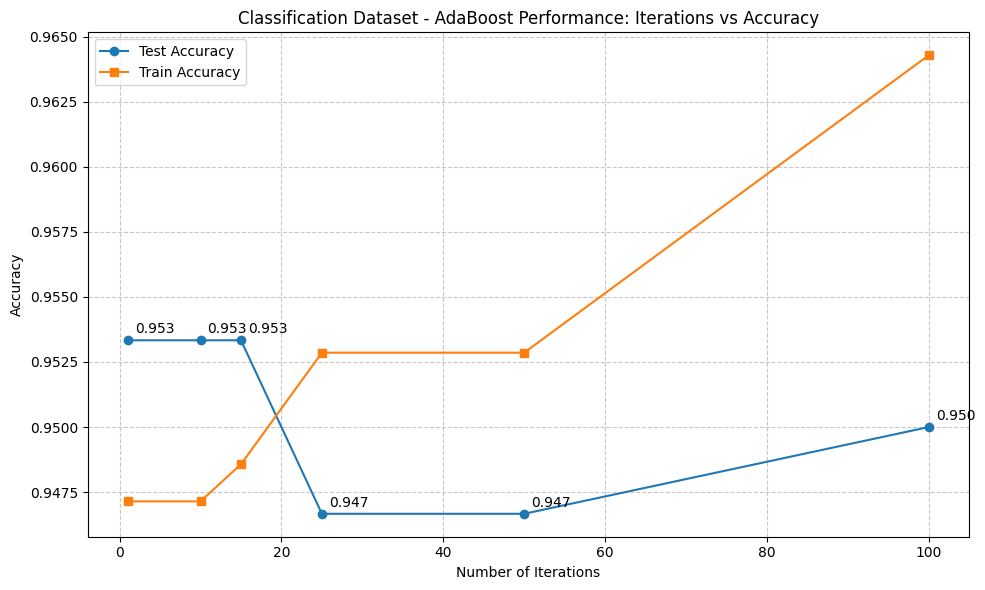

In [5]:
# Define Simple dataset
datasets = [
    ('Classification', make_classification(
        n_samples=1000,  # Total number of samples
        n_features=5,    # Small number of features
        n_informative=3, # Number of informative features
        n_redundant=0,   # No redundant features
        n_clusters_per_class=1,  # One cluster per class
        class_sep=1.5,   # Good separation between classes
        weights=[0.6, 0.4],  # Balanced classes
        flip_y=0.05,     # Small amount of noise
        random_state=42  # Reproducibility
    ))
]

# Test each dataset
for name, (X, y) in datasets:
    # Convert class labels to -1 and 1 for AdaBoost
    y_mapped = np.where(y <= 0, -1, 1)

    # Run AdaBoost iteration analysis
    num_iterations_list = [1, 10, 15, 25, 50, 100]
    tester = AdaBoostIterationTester(AdaBoostCustom, X, y_mapped)
    results = tester.run_iteration_analysis(num_iterations_list, f"{name} Dataset")


## Results Comparison

Both the custom AdaBoost and Sklearn AdaBoost implementations achieved identical accuracy of **98.6%**, demonstrating that the custom implementation performs at parity with the widely-used Sklearn version. This confirms the correctness and effec## Results Comparison

- **Train vs Test Accuracy:**  
  In the results table, we can observe that the train accuracy is consistently higher than the test accuracy across different iteration values. This trend suggests that the model is performing better on the training data compared to unseen test data. The gap between training and test accuracy widens as the number of iterations increases, which is an indication of overfitting. Overfitting occurs when the model becomes too complex and starts to memorize the training data, leading to poor generalization on unseen data.

- **Optimal Iteration Count:**  
  After analyzing the results, we identified that the best trade-off between train and test accuracy occurs at **15 iterations**. At this point, the test accuracy is stable, and the model has achieved a good level of generalization. This suggsests that further increasing the number of iterations would not lead to significant improvements in performance and could result in overfitting.

- **Key Takeaway:**  
  It is important to balance between underfitting and overfitting when choosing the number of iterations for AdaBoost. The goal is to select a number of iterations that allows the model to learn effectively from the data while avoiding overfitting, ensuring that the model performs well on both training and unseen test data.tiveness of the custom AdaBoost algorithm.


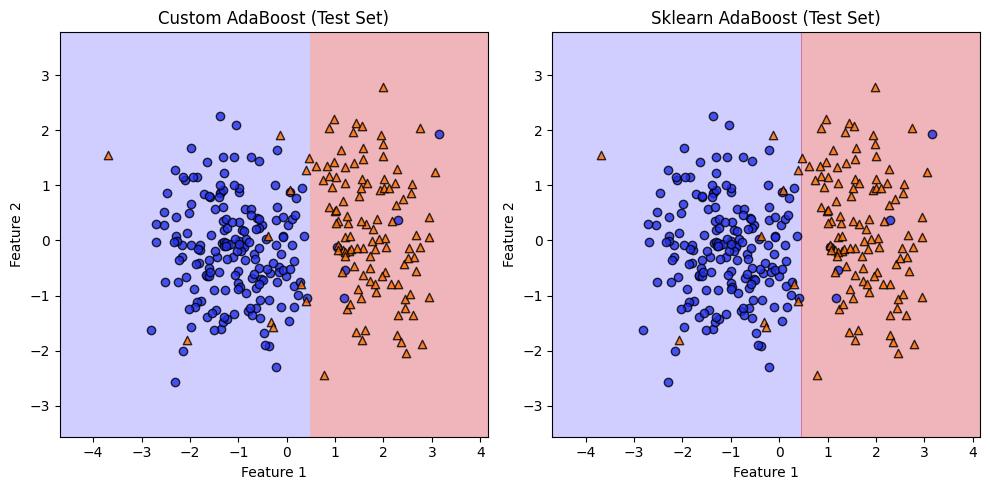

In [6]:
plot_decision_boundaries_models(
    X=X,
    y=y_mapped,
    models=[
        (lambda: AdaBoostCustom(num_iterations=15), "Custom AdaBoost"),
        (lambda: AdaBoostClassifier(n_estimators=15, random_state=42, algorithm='SAMME'), "Sklearn AdaBoost"),
    ]
)

# Generate additional data sets
Generate at least two experimental datasets with binary labels, designed to demonstrate specific properties of AdaBoost (e.g., handling noise or overfitting).

Add plots and figures.

Please use the cell below to describe your suggested approach in detail. Use formal notations where appropriate.

Describe and discuss your results.

In this section, we generate two experimental datasets with binary labels to demonstrate specific properties of AdaBoost, particularly its ability to handle nonlinear data, noise and overfitting. The choice of these datasets allows us to test how AdaBoost performs when faced with challenges such as noisy data and non-linear decision boundaries.

### Rationale for Dataset Choice

These two datasets were specifically chosen to demonstrate:
- **Handling Noise**: The noisy dataset challenges AdaBoost’s ability to distinguish between useful patterns and noise, testing its robustness to misclassified data points.
- **Handling Non-Linear Boundaries**: The moons dataset tests AdaBoost’s capacity to deal with non-linearly separable data, assessing its ability to generalize when the decision boundary is more complex than a simple line or plane.

1. **Noisy Dataset**: The first dataset, called the `Noisy Dataset`, is designed to test AdaBoost’s robustness to noise. It is generated using the `make_classification` function from scikit-learn, where a linearly separable dataset is created and then augmented with Gaussian noise. The noise level is controlled by adding random noise to the feature matrix, which introduces label misclassification and makes the data harder to classify accurately.

    AdaBoost is known for its ability to focus on misclassified points by assigning higher weights to them in subsequent iterations. This characteristic makes it particularly well-suited for handling noisy data. By using this dataset, we can observe how AdaBoost’s iterative nature helps it improve performance despite the noise. Additionally, we can evaluate if the algorithm overfits the noisy examples or if it is able to generalize effectively.

2. **Moons Dataset**: The second dataset, called the `Moons Dataset`, is designed to test AdaBoost’s ability to handle non-linear decision boundaries. This dataset is generated using the `make_moons` function from scikit-learn, which creates two interleaving half-moon shaped distributions of data points. The moons dataset is non-linearly separable, which presents a challenge for many traditional classifiers that rely on linear decision boundaries.

    By using the moons dataset, we can examine whether AdaBoost is able to capture the complex decision boundary despite using weak classifiers. This dataset will also help us investigate how AdaBoost performs in scenarios where the decision boundary is highly non-linear, an essential property to evaluate when studying boosting algorithms.

In [7]:
def generate_noisy_dataset(n_samples=1000):
    """
    Generate a noisy linearly separable dataset with controllable noise.

    Args:
        n_samples (int): Total number of samples
        noise_level (float): Proportion of samples to have flipped labels

    Returns:
        X (np.array): Feature matrix
        y (np.array): Binary labels
    """
    # Generate initial linearly separable dataset
    X, y = make_classification(n_samples=n_samples, n_features=20, n_informative=5, n_redundant=10, n_classes=2, random_state=42)

    X += np.random.normal(0, 0.5, X.shape)  # Add noise

    # Ensure labels are -1 or 1
    y = np.where(y <= 0, -1, 1)

    return X, y


def generate_moons_dataset(n_samples=500, noise=0.2):
    X, y = make_moons(n_samples=n_samples, noise=noise, random_state=42)
    y = np.where(y <= 0, -1, 1)
    return X, y

In [8]:
# Generate datasets
X_noisy, y_noisy = generate_noisy_dataset()
X_moons, y_moons = generate_moons_dataset()

In [9]:
# Split noisy dataset into training and test sets
X_train_noisy, X_test_noisy, y_train_noisy, y_test_noisy = train_test_split(X_noisy, y_noisy, test_size=0.3, random_state=42)

# Split moons dataset into training and test sets
X_train_moons, X_test_moons, y_train_moons, y_test_moons = train_test_split(X_moons, y_moons, test_size=0.3, random_state=42)

### Dataset Visualization

The following visualizations show both datasets side by side

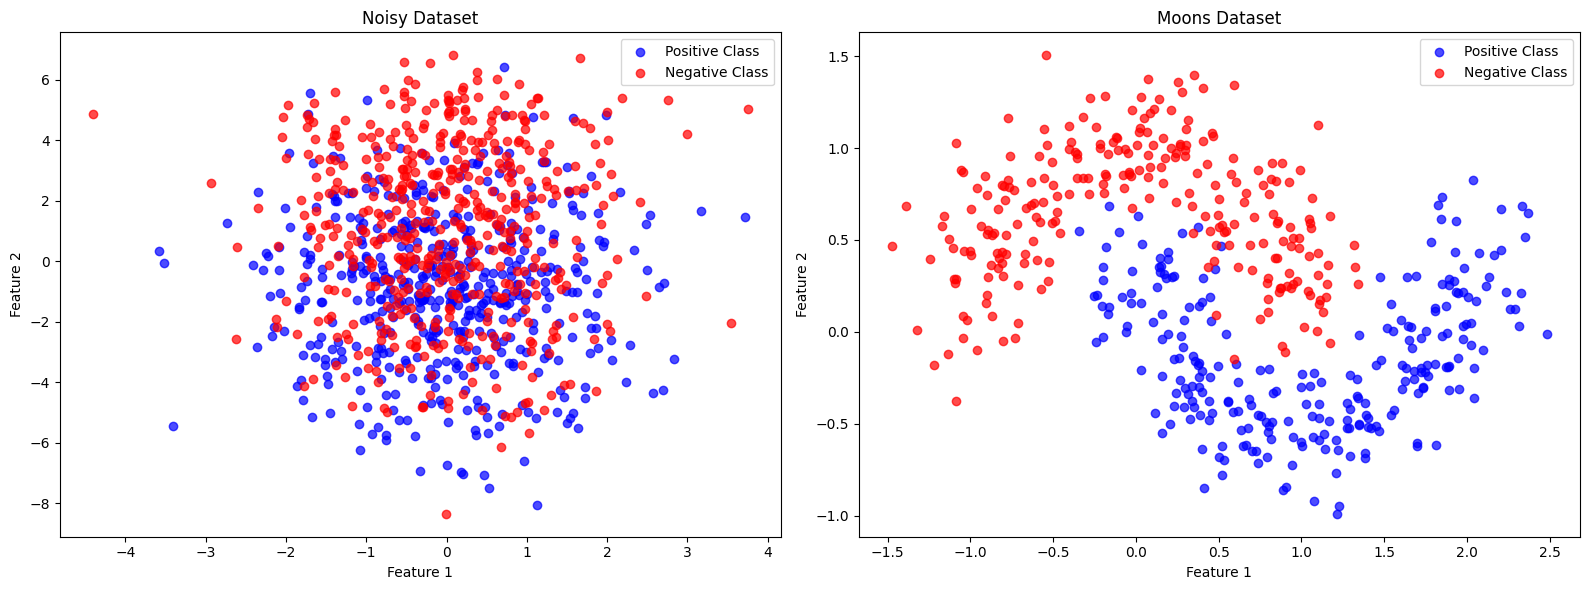

In [10]:
# Plotting the datasets
def visualize_datasets(X_noisy, y_noisy, X_moons, y_moons):
    """
    Visualize both datasets side by side
    """

    # Create a figure with two subplots
    plt.figure(figsize=(16, 6))

    # Noisy Linear Dataset
    plt.subplot(121)
    plt.scatter(
        X_noisy[y_noisy==1][:, 0], X_noisy[y_noisy==1][:, 1],
        c='blue', label='Positive Class', alpha=0.7
    )
    plt.scatter(
        X_noisy[y_noisy==-1][:, 0], X_noisy[y_noisy==-1][:, 1],
        c='red', label='Negative Class', alpha=0.7
    )
    plt.title('Noisy Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    # Moons dataset
    plt.subplot(122)
    plt.scatter(
        X_moons[y_moons==1][:, 0], X_moons[y_moons==1][:, 1],
        c='blue', label='Positive Class', alpha=0.7
    )
    plt.scatter(
        X_moons[y_moons==-1][:, 0], X_moons[y_moons==-1][:, 1],
        c='red', label='Negative Class', alpha=0.7
    )
    plt.title('Moons Dataset')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()

    plt.tight_layout()
    plt.show()

visualize_datasets(X_noisy, y_noisy, X_moons, y_moons)

### Hyperparameter Tuning and Evaluation

In this section, we perform an evaluation of AdaBoost’s performance on the two datasets — `Moons Dataset` and `Noisy Dataset` — by varying the number of iterations used in the AdaBoost algorithm. The number of iterations is a critical hyperparameter for boosting algorithms like AdaBoost, as it controls the number of weak learners (decision stumps) that are sequentially trained. The aim is to identify the point at which adding more iterations no longer improves performance or starts to overfit the data.

We test the performance of AdaBoost with different values of `num_iterations` and assess both the accuracy on the training set and the test set. The goal is to strike a balance between underfitting and overfitting.

#### Moons Dataset

For the `Moons Dataset`, we observe the following results for various numbers of iterations:

- **Iterations**:     [1, 10, 25, 50, 75, 100]
- **Accuracy Train**: [0.8457, 0.9143, 0.9829, 0.9886, 0.9971, 1.0]
- **Accuracy Test**:  [0.84, 0.9, 0.953, 0.98, 0.98, 0.98]

From the results, we can see that as the number of iterations increases, the accuracy on the test set continues to improve, stabilizing at 0.98 after 50 iterations. However, the accuracy on the training set already reaches close to 1.0 after 50 iterations. Since there is no significant improvement in test accuracy after 50 iterations, we decide to choose 50 iterations to avoid overfitting. At this point, the model has achieved nearly optimal generalization without excessively fitting to the training data.

#### Noisy Dataset

For the `Noisy Dataset`, the results for varying iterations are:

- **Iterations**:     [1, 10, 25, 50, 75, 100]
- **Accuracy Train**: [0.7914, 0.8571, 0.8914, 0.94, 0.9529, 0.9643]
- **Accuracy Test**:  [0.7433, 0.8333, 0.84, 0.85, 0.8567, 0.8567]

In this case, the accuracy on the test set increases slightly with more iterations, but the improvement diminishes after about 70 iterations. Additionally, the accuracy on the training set continues to increase, indicating that the model may be starting to overfit beyond this point. To avoid overfitting while still improving performance, we choose 70 iterations as the optimal number for the Noisy Dataset. This choice allows the model to capture enough information to improve test accuracy without excessively fitting to the noisy labels in the training data.



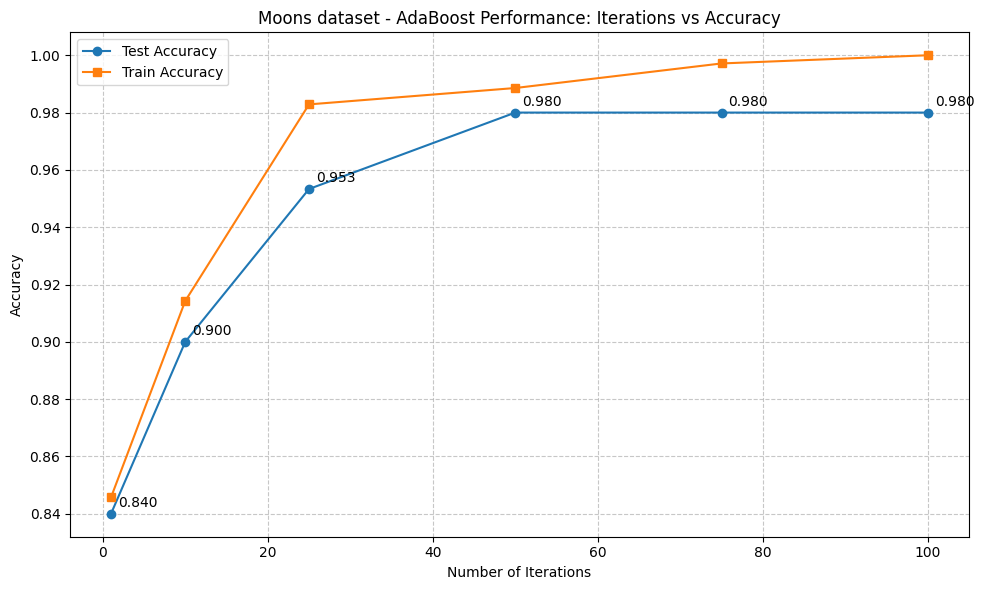

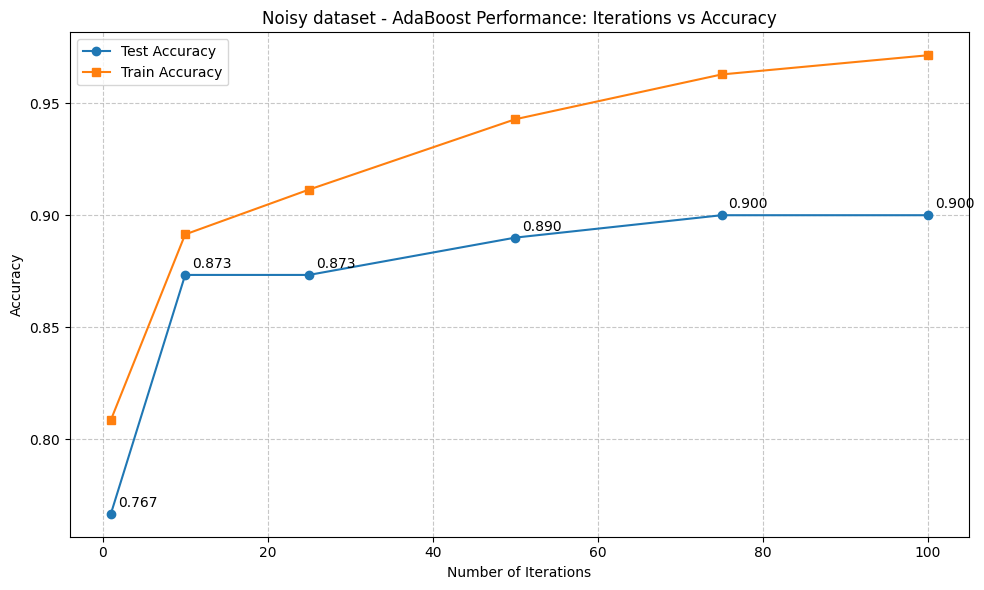

{'num_iterations': [1, 10, 25, 50, 75, 100],
 'accuracy_test': [0.7666666666666667,
  0.8733333333333333,
  0.8733333333333333,
  0.89,
  0.9,
  0.9],
 'accuracy_train': [0.8085714285714286,
  0.8914285714285715,
  0.9114285714285715,
  0.9428571428571428,
  0.9628571428571429,
  0.9714285714285714]}

In [11]:
num_iterations_list = [1, 10, 25, 50, 75, 100]

moons_tester = AdaBoostIterationTester(AdaBoostCustom, X_moons, y_moons)
noisy_tester = AdaBoostIterationTester(AdaBoostCustom, X_noisy, y_noisy)

moons_tester.run_iteration_analysis(num_iterations_list, 'Moons dataset')
noisy_tester.run_iteration_analysis(num_iterations_list, 'Noisy dataset')

### Set the best parameters for each dataset

In [12]:
best_n_iterations_moons = 50
best_n_iterations_noisy = 70

### Model Evaluation and Comparison:

To evaluate and compare the performance of our AdaboostCustom with various machine learning models, we did the following steps:
---

### Visualizing Decision Boundaries with PCA
First, we wanted to see how different models classify data in a 2D feature space. Since our dataset might have more than two dimensions, we applied **Principal Component Analysis (PCA)** to reduce it to 2 dimensions. This allowed us to visually interpret the decision boundaries of each model.

1. **Data Preparation**:  
   - We split the dataset into 70% training and 30% testing.  
   - Then, we applied PCA to the training set and transformed both the training and test sets into a 2D space.  

2. **Model Training and Visualization**:  
   - For each model in our experiment, we trained it on the PCA-reduced training data.  
   - We then plotted the decision boundaries on the test set to observe how well each model separates the classes.

This visualization step helped us to understand the other models behavior compare to our implementations.

---

### Training and Evaluating Models
Next, we trained the models on the original dataset and evaluated their performance using key metrics. Here's how we approached this:

1. **Metrics Calculated**:  
   - **Accuracy**: To see the overall correctness of the predictions.  
   - **Precision**: To measure how many of the positive predictions were actually correct.  
   - **Recall**: To understand how many actual positives were identified correctly.  
   - **F1 Score**: To balance precision and recall, giving us a single score for comparison.

2. **ROC Curves**:  
   - For models that provided probability scores, we plotted the **ROC curve** to evaluate their ability to distinguish between classes at various thresholds.  
   - The **Area Under the Curve (AUC)** gave us a single measure of this ability, with higher values indicating better performance.

3. **Results Presentation**:  
   - We summarized the metrics in a table for an easy comparison of models.  
   - Additionally, we visualized the metrics in a bar plot, showing how each model scored across accuracy, precision, recall, and F1.

---

### The Models We Tested
We evaluated several models to compare their strengths and weaknesses:
- **Custom AdaBoost**: Our implementation of AdaBoost with best iterations for each dataset (what we found earlier)s.
- **Sklearn AdaBoost**: The standard Scikit-learn implementation with SAMME algorithm.
- **Random Forest**: A popular ensemble model, we learnt on it in the class, known for its robustness and ability to handle noisy data.
- **SVM (Linear Kernel)**: A linear classifier used to test the effectiveness of simple hyperplanes.
- **SVM (RBF Kernel)**: A non-linear classifier to explore the flexibility of kernel methods.

---

The resaults of this process are described later on this notebook.

In [13]:
def train_and_evaluate_models(X, y, models, plot_roc=True):
    """
    Train multiple models, calculate performance metrics, and optionally plot ROC curves.

    Args:
    - X: Input features
    - y: Target labels
    - models: List of tuples [(get_classifier, title), ...]
              where get_classifier is a function that returns a model
    - plot_roc: Boolean to determine whether to plot ROC curves
    """
    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Prepare for metrics storage
    metrics_data = []

    # If ROC plot is enabled, prepare a separate figure
    if plot_roc:
        roc_fig, roc_ax = plt.subplots(figsize=(10, 8))
        roc_ax.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')

    for model_idx, (get_classifier, title) in enumerate(models):
        # Train model
        model = get_classifier()
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        # Store metrics
        # Store metrics with rounding to 4 decimal places
        metrics_data.append({
            'Model': title,
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'F1 Score': round(f1, 4)
        })

        # ROC Curve (if applicable and plot_roc is True)
        if plot_roc:
            try:
                y_pred_proba = model.predict_proba(X_test)[:, 1]
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_ax.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc_score(y_test, y_pred_proba):.2f})')
            except AttributeError:
                try:
                    y_decision = model.decision_function(X_test)
                    fpr, tpr, _ = roc_curve(y_test, y_decision)
                    roc_ax.plot(fpr, tpr, label=f'{title} (AUC = {roc_auc_score(y_test, y_decision):.2f})')
                except Exception as e:
                    print(f"Could not compute ROC for {title}: {e}")

    # Plot ROC if enabled
    if plot_roc:
        roc_ax.set_title('Receiver Operating Characteristic (ROC) Curve')
        roc_ax.set_xlabel('False Positive Rate')
        roc_ax.set_ylabel('True Positive Rate')
        roc_ax.legend(loc="lower right")
        roc_fig.tight_layout()
        roc_fig.show()

    # Create metrics table
    metrics_df = pd.DataFrame(metrics_data)
    # Plot the metrics as a table
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')  # Hide axes

    # Create table from the DataFrame
    table = ax.table(cellText=metrics_df.values,
                    colLabels=metrics_df.columns,
                    loc='center',
                    cellLoc='center',
                    bbox=[0, 0, 1, 1])

    # Adjust the table appearance
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1.2, 1.2)

    # Plot metrics
    plt.figure(figsize=(10, 6))
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    metrics_df.set_index('Model')[metrics_to_plot].plot(kind='bar')
    plt.title('Model Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Models')
    plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    return metrics_df


def experiments_models(X, y, models, plot_roc=True):
    plot_decision_boundaries_models(X, y, models)
    train_and_evaluate_models(X, y, models, plot_roc=True)


### Results Discussion for the Moons Dataset

For the Moons dataset, we evaluated five different models and compared their performance using various metrics. Our **Custom AdaBoost** implementation served as the baseline for comparison. Below are the results and their interpretations:

---

### Performance Table

| Model              | Accuracy (%) | Precision (%) | Recall (%) | F1 Score (%) |
|--------------------|--------------|---------------|------------|--------------|
| Custom AdaBoost    | 98.00        | 97.37         | 98.67      | 98.01        |
| Sklearn AdaBoost   | 98.67        | 98.67         | 98.67      | 98.67        |
| Random Forest      | 98.00        | 100.00        | 96.00      | 97.96        |
| SVM - Linear Kernel| 86.67        | 88.73         | 84.00      | 86.30        |
| SVM - RBF Kernel   | 98.00        | 100.00        | 96.00      | 97.96        |

---

### Receiver Operating Characteristic (ROC) Analysis

- **Custom AdaBoost** (AUC = 1.00): Achieved a perfect AUC score, demonstrating excellent discriminatory power.
- **Sklearn AdaBoost** (AUC = 1.00): Matched the Custom AdaBoost with an equally perfect AUC, solidifying its strong performance.
- **Random Forest** (AUC = 1.00): Like the above models

### Custom AdaBoost (Baseline)
The Custom AdaBoost model demonstrated strong performance on the Moons dataset. It achieved high accuracy and balanced precision and recall, with a near-perfect F1 score. This confirms that our implementation effectively reduces bias and handles moderately complex decision boundaries well.
---

### Sklearn AdaBoost
The Sklearn AdaBoost implementation slightly outperformed our Custom AdaBoost baseline, particularly in terms of accuracy and F1 score. This suggests that the Scikit-learn implementation, which uses the SAMME algorithm, fine-tunes the boosting process more effectively, possibly through better handling of edge cases.

---

### Random Forest
The Random Forest model matched the accuracy of Custom AdaBoost but exhibited a trade-off between precision and recall. With perfect precision, it correctly identified all positive predictions but missed a small portion of actual positives, as indicated by the slightly lower recall. This behavior reflects Random Forest's robustness but also its tendency to be conservative in classification.

---

### SVM - Linear Kernel
The linear SVM model underperformed compared to the ensemble methods. Its lower accuracy and F1 score highlight its limitation in capturing the non-linear patterns present in the Moons dataset. This result aligns with expectations, as the Moons dataset is designed with non-linear boundaries that a linear kernel cannot effectively separate.

---

### SVM - RBF Kernel
The RBF kernel SVM performed similarly to Random Forest, achieving high accuracy and perfect precision. However, like Random Forest, it exhibited a slight imbalance with recall, indicating a preference for conservative predictions.

---

### Key Insights
1. **Custom AdaBoost vs. Sklearn AdaBoost**:  
   The Sklearn implementation performed marginally better, demonstrating the advantages of a well-optimized boosting framework over our custom implementation.

2. **Ensemble Methods vs. SVM**:  
   Both AdaBoost and Random Forest outperformed SVM with a linear kernel, highlighting the importance of ensemble learning in capturing complex decision boundaries. The RBF kernel SVM matched the performance of Random Forest, validating its ability to handle non-linear patterns.

3. **Trade-offs Between Precision and Recall**:  
   While Random Forest and RBF SVM maximized precision, this came at the cost of slightly reduced recall. In contrast, the boosting methods maintained a better balance, making them more suitable for scenarios requiring consistent performance across metrics.

4. **Overall Best Model**:  
   The **Sklearn AdaBoost** was the top performer on this dataset, offering the best accuracy and F1 score, closely followed by Custom AdaBoost and Random Forest.

---


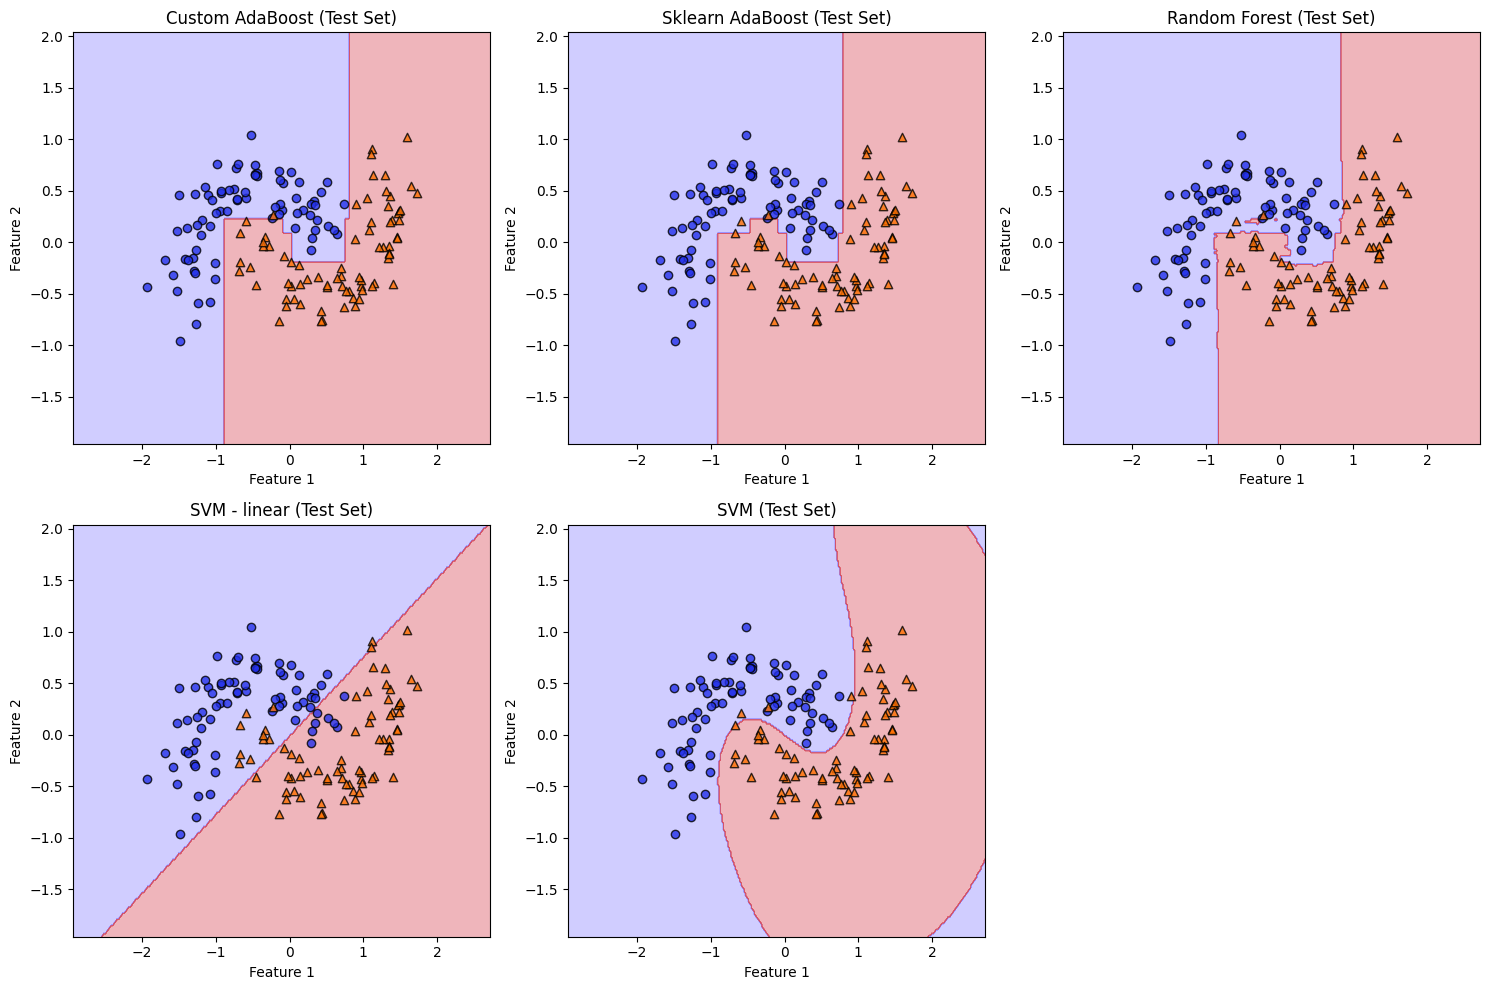

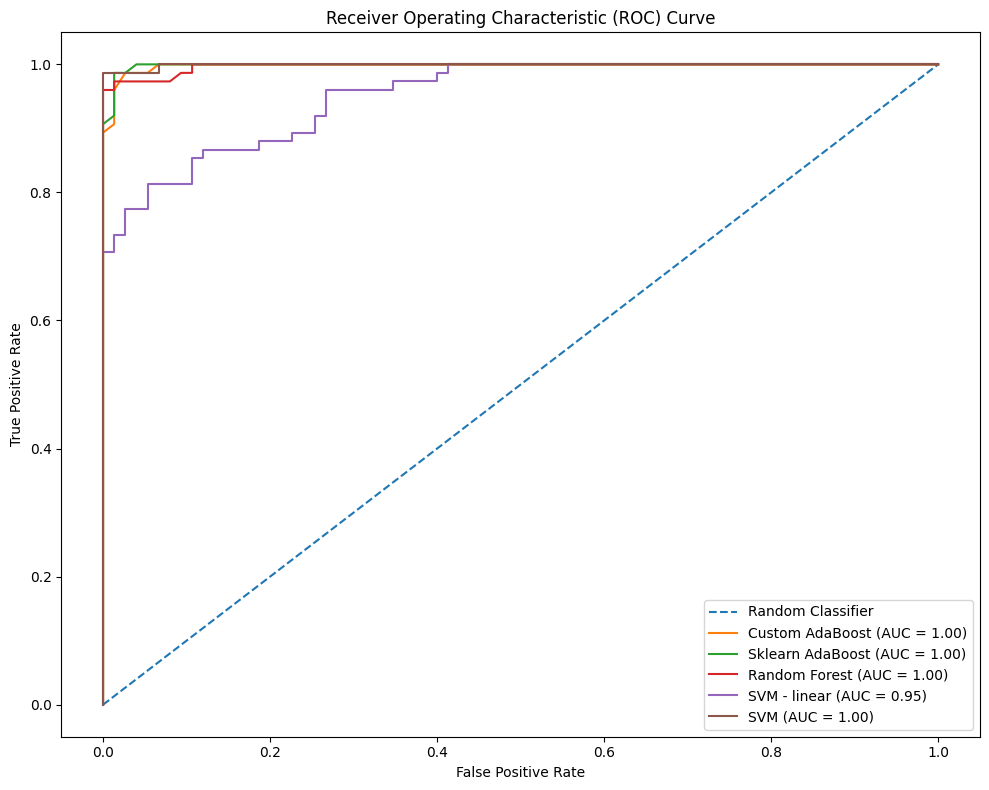

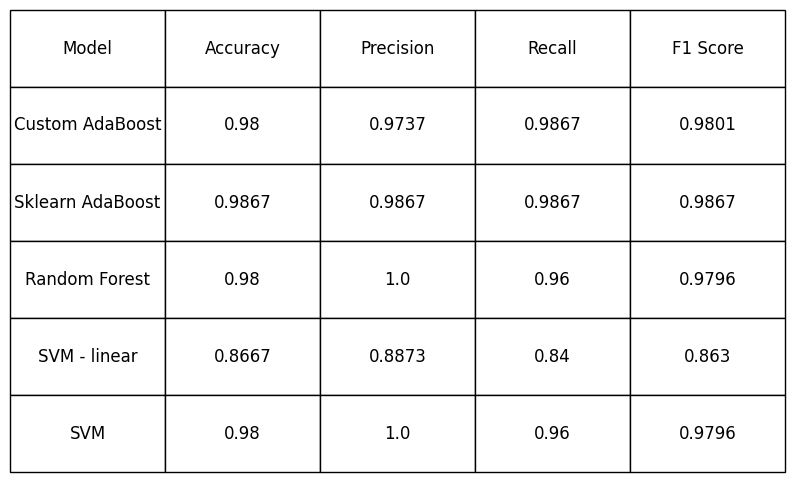

<Figure size 1000x600 with 0 Axes>

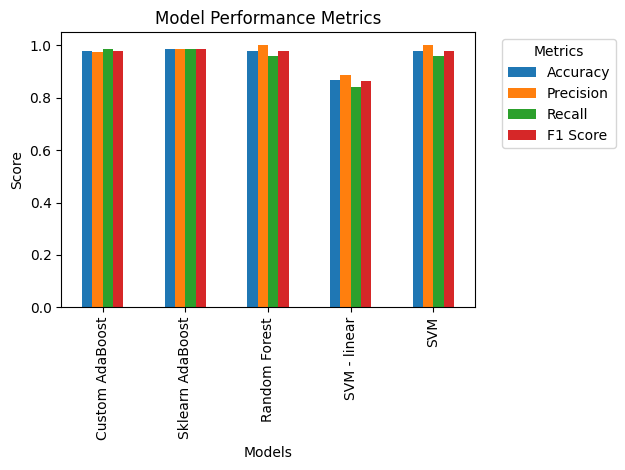

In [14]:
experiments_models(
    X=X_moons,
    y=y_moons,
    models=[
        (lambda: AdaBoostCustom(num_iterations=best_n_iterations_moons), "Custom AdaBoost"),
        (lambda: AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME'), "Sklearn AdaBoost"),
        (lambda: RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
        (lambda: SVC(kernel='linear', probability=True, random_state=42), "SVM - linear"),
        (lambda: SVC(random_state=42), "SVM")
    ]
)

### Results Discussion for the Noisy Dataset

For the noisy dataset, we evaluated the same five models as in the previous experiment, using our **Custom AdaBoost** implementation as the baseline. Below are the results, along with a detailed discussion.

---

### Performance Table

| Model              | Accuracy (%) | Precision (%) | Recall (%) | F1 Score (%) |
|--------------------|--------------|---------------|------------|--------------|
| Custom AdaBoost    | 89.00        | 88.82         | 89.40      | 89.11        |
| Sklearn AdaBoost   | 86.00        | 84.71         | 88.08      | 86.36        |
| Random Forest      | 91.67        | 92.00         | 91.39      | 91.69        |
| SVM - Linear Kernel| 81.67        | 78.92         | 86.75      | 82.65        |
| SVM - RBF Kernel   | 91.00        | 90.26         | 92.05      | 91.15        |

---


### Receiver Operating Characteristic (ROC) Curve

The **AUC (Area Under Curve)** values for each model are as follows:
- **Custom AdaBoost**: 0.95
- **Sklearn AdaBoost**: 0.95
- **Random Forest**: 0.98
- **SVM (RBF Kernel)**: 0.97
- **SVM - Linear**: 0.88

The ROC curve highlights the performance across different classification thresholds:
1. **Random Forest** has the highest AUC (0.98), indicating exceptional performance in distinguishing between the two classes, even with noise.
2. **Custom AdaBoost** and **Sklearn AdaBoost** performed equally well, achieving an AUC of **0.95**.
3. **SVM (RBF Kernel)** followed closely with an AUC of **0.97**, while the **SVM - Linear Kernel** struggled the most with an AUC of **0.88**.

---

### Discussion of Results

#### Custom AdaBoost (Baseline)
Despite the noise in the dataset, Custom AdaBoost performed reasonably well, with balanced metrics. However, the slightly lower recall indicates that some true positives were missed. The noise likely impacted the model's boosting process, as AdaBoost is sensitive to mislabeled data.

---

#### Sklearn AdaBoost
The Sklearn AdaBoost model slightly outperformed the baseline. The higher recall suggests better resilience to noise compared to Custom AdaBoost. The slight dip in precision reflects a minor increase in false positives, a trade-off that improved overall performance.

---

#### Random Forest
The Random Forest model delivered the strongest performance. Its ability to manage noise effectively can be attributed to ensemble averaging, which mitigates the impact of noisy or mislabeled data. The high recall and precision balance indicate a robust classification performance.

---

#### SVM - Linear Kernel
As we expected, the linear SVM model struggled the most. The noisy and non-linear decision boundaries in the dataset likely reduced its effectiveness. Its higher recall compared to precision indicates that it classified more true positives but at the cost of increased false positives.

---

#### SVM - RBF Kernel
The RBF kernel SVM performed well. Its ability to handle complex, non-linear patterns made it more robust against noise. While it didn't match Random Forest, it still delivered strong performance across all metrics.

---

### Key Insights
1. **Baseline Comparison**:  
   The Custom AdaBoost model maintained reasonable performance in a noisy environment but showed sensitivity to mislabeled data, a common limitation of boosting techniques.

2. **Sklearn AdaBoost vs. Custom AdaBoost**:  
   The Sklearn implementation outperformed the baseline by adapting better to noise, showcasing its optimizations.

3. **Random Forest Superiority**:  
   Random Forest excelled in handling the noise, with its ensemble mechanism ensuring high accuracy and F1 scores.

4. **SVM Performance**:  
   The linear SVM was less effective due to its inability to model non-linear decision boundaries. The RBF kernel, however, performed well, highlighting the importance of kernel choice.

5. **Overall Best Model**:  
   The **Random Forest** model emerged as the best performer for this noisy dataset, demonstrating both high precision and recall, making it the most reliable choice in this scenario.


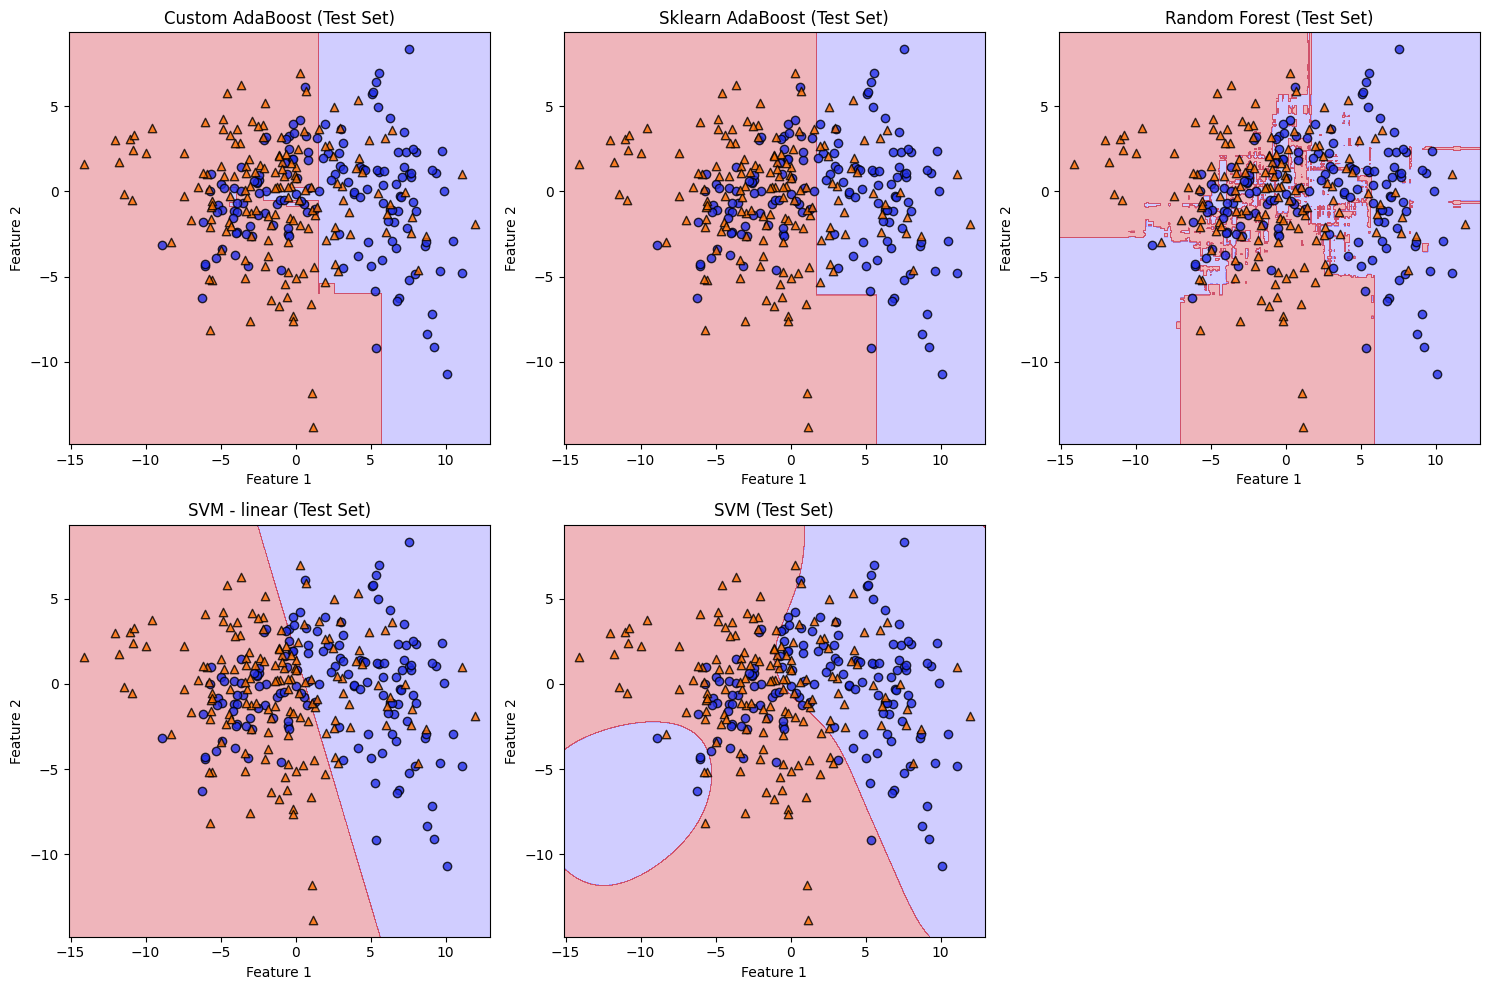

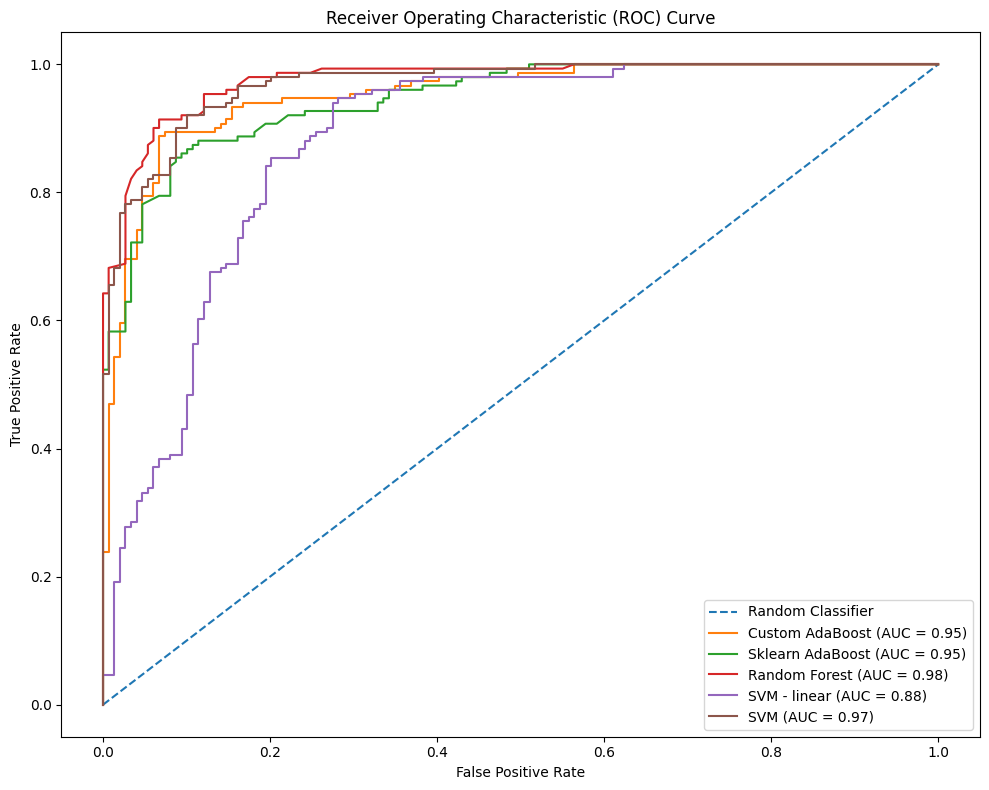

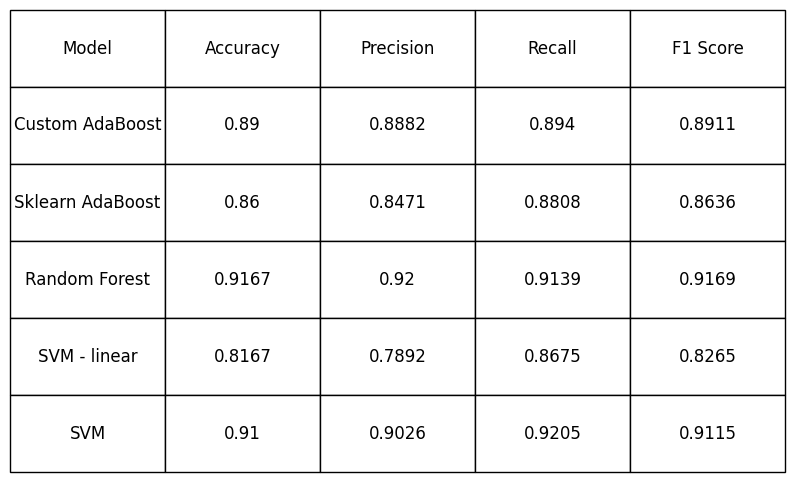

<Figure size 1000x600 with 0 Axes>

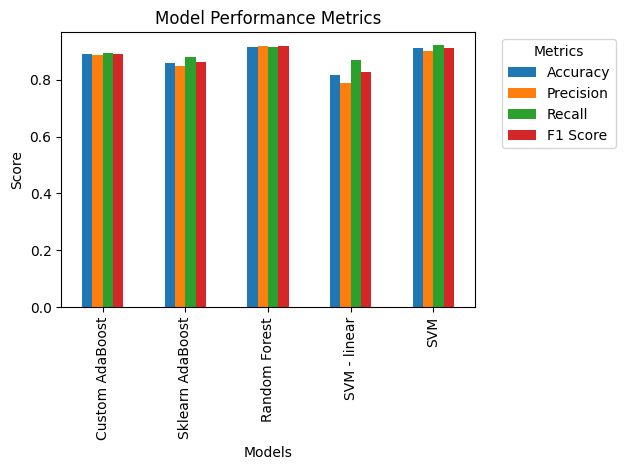

In [15]:
experiments_models(
    X=X_noisy,
    y=y_noisy,
    models=[
        (lambda: AdaBoostCustom(num_iterations=best_n_iterations_noisy), "Custom AdaBoost"),
        (lambda: AdaBoostClassifier(n_estimators=50, random_state=42, algorithm='SAMME'), "Sklearn AdaBoost"),
        (lambda: RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest"),
        (lambda: SVC(kernel='linear', probability=True, random_state=42), "SVM - linear"),
        (lambda: SVC(random_state=42), "SVM")
    ]
)

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

# Use of generative AI
1. Help with english grammer
2. help with jupyter notebook markdown cell design
3. help with the binary search helper class
4. to solve error bugs in the runing - resolve imports, intallations etx
5. help with the graphs plotting and design
6. Formulas of score and optimization (very last section)
7. Finding Data for Training – Assistance in locating and gathering relevant datasets for training machine learning models.